In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Note!! In the data below, it seems that the direction of hidden liquidity execution is always 1. This needs to be modified to be more general later.

In [3]:
MSFT_m = pd.read_csv("./data/MSFT/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/MSFT/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)


In [4]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction']

MSFT_m.columns = M_header


OB_header = []
for i in range(1, MSFT_ob.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

MSFT_ob.columns = OB_header

In [5]:
MSFT_m['time'] = pd.to_timedelta(MSFT_m['time'], unit='s')

# Define the base date
base_date = pd.Timestamp('2012-06-21')

# Add the timedelta (time_sec) to the base date
MSFT_m['datetime'] = base_date + MSFT_m['time']

MSFT_m.drop(columns=['time'], inplace=True)


In [6]:
# Creating event number
MSFT_m['event_number'] = MSFT_m.groupby('datetime').cumcount()
MSFT_m['event_number_at_t'] = MSFT_m.groupby('datetime')['event_type'].transform('count')

# Setting the composite index
MSFT_m.set_index(['datetime', 'event_number'], inplace=True)

In [7]:
MSFT_ob.index = MSFT_m.index

In [8]:
MSFT_ob_L1 = MSFT_ob.iloc[:, :4]

In [9]:
MSFT_ob_L1['ask_price_1_prev'] = MSFT_ob_L1['ask_price_1'].shift()
MSFT_ob_L1['ask_size_1_prev'] = MSFT_ob_L1['ask_size_1'].shift()
MSFT_ob_L1['bid_price_1_prev'] = MSFT_ob_L1['bid_price_1'].shift()
MSFT_ob_L1['bid_size_1_prev'] = MSFT_ob_L1['bid_size_1'].shift()

In [10]:
# Define the start and end times
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:45:00").time()

# Extract the 'datetime' level from the MultiIndex and filter based on the time
filtered_index = MSFT_m.index.get_level_values('datetime').to_series().between_time(start_time, end_time).index

# Use the filtered index to get the filtered DataFrame
MSFT_m_mh = MSFT_m.loc[filtered_index]
MSFT_ob_L1_mh = MSFT_ob_L1.loc[filtered_index]

In [11]:
MSFT_m_mh = MSFT_m_mh[~MSFT_m_mh.index.duplicated(keep='first')]
MSFT_ob_L1_mh = MSFT_ob_L1_mh[~MSFT_ob_L1_mh.index.duplicated(keep='first')]


In [12]:
MSFT_m_hid_mh = MSFT_m_mh[MSFT_m_mh['event_type']==5]
MSFT_m_hid_mh = MSFT_m_hid_mh.merge(MSFT_ob_L1_mh, left_index=True, right_index=True, how='inner')

In [13]:
MSFT_m_hid_mh

event_type  order_ID  size  \
datetime                      event_number                               
2012-06-21 09:30:00.039883970 0                      5         0   300   
                              1                      5         0    27   
2012-06-21 09:30:01.628977093 2                      5         0   579   
2012-06-21 09:30:01.746521107 0                      5         0    21   
2012-06-21 09:30:02.214995101 0                      5         0   100   
...                                                ...       ...   ...   
2012-06-21 15:44:42.381660261 0                      5         0   100   
2012-06-21 15:44:42.401199104 0                      5         0   200   
2012-06-21 15:44:46.255166394 0                      5         0   200   
2012-06-21 15:44:54.939982778 3                      5         0   100   
                              4                      5         0   400   

                                             price  direction  \
datetime                      event_number                      
2012-06-21 09:30:00.039883970 0             309600         -1   
                              1             309700         -1   
2012-06-21 09:30:01.628977093 2             309900          1   
2012-06-21 09:30:01.746521107 0             309900          1   
2012-06-21 09:30:02.214995101 0             309650         -1   
...                                            ...        ...   
2012-06-21 15:44:42.381660261 0             301450         -1   
2012-06-21 15:44:42.401199104 0             301450         -1   
2012-06-21 15:44:46.255166394 0             301350         -1   
2012-06-21 15:44:54.939982778 3             301400         -1   
                              4             301400         -1   

                                            event_number_at_t  ask_price_1  \
datetime                      event_number                                   
2012-06-21 09:30:00.039883970 0                             2       309900   
                              1                             2       309900   
2012-06-21 09:30:01.628977093 2                             3       310000   
2012-06-21 09:30:01.746521107 0                             1       310000   
2012-06-21 09:30:02.214995101 0                             1       309700   
...                                                       ...          ...   
2012-06-21 15:44:42.381660261 0                             1       301500   
2012-06-21 15:44:42.401199104 0                             1       301500   
2012-06-21 15:44:46.255166394 0                             1       301400   
2012-06-21 15:44:54.939982778 3                             5       301500   
                              4                             5       301500   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.039883970 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:01.628977093 2                  23106       309700   
2012-06-21 09:30:01.746521107 0                  22906       309700   
2012-06-21 09:30:02.214995101 0                   3000       309600   
...                                                ...          ...   
2012-06-21 15:44:42.381660261 0                  11484       301400   
2012-06-21 15:44:42.401199104 0                  11484       301400   
2012-06-21 15:44:46.255166394 0                  18530       301300   
2012-06-21 15:44:54.939982778 3                  11284       301300   
                              4                  11284       301300   

                                            bid_size_1  ask_price_1_prev  \
datetime                      event_number                                 
2012-06-21 09:30:00.039883970 0                    300          309900.0   
                              1                    300          3099

In [14]:
MSFT_m_hid_mh['midprice'] = (MSFT_m_hid_mh['ask_price_1'] + MSFT_m_hid_mh['bid_price_1']) / 2

Indicator for whether hidden liquidity is at the best bid or ask

In [15]:
MSFT_m_hid_mh['hid_at_best'] = np.where(
    MSFT_m_hid_mh['direction'] == 1, 
    MSFT_m_hid_mh['price'] == MSFT_m_hid_mh['bid_price_1'], 
    MSFT_m_hid_mh['price'] == MSFT_m_hid_mh['ask_price_1']
)

How to query particular timestamp.

In [16]:
# specific_timestamp = pd.Timestamp('2019-01-02 12:36:22.263095939')
# MSFT_m.index.get_loc((specific_timestamp, 0))
# MSFT_m[MSFT_m.index.get_level_values('datetime') == specific_timestamp]

In [17]:
MSFT_m_hid_mh['agg_ratio'] = np.where(
    MSFT_m_hid_mh['direction'] == 1, 
    (MSFT_m_hid_mh['price'] - MSFT_m_hid_mh['bid_price_1']) / (MSFT_m_hid_mh['ask_price_1'] - MSFT_m_hid_mh['bid_price_1']), 
    (MSFT_m_hid_mh['ask_price_1'] - MSFT_m_hid_mh['price']) / (MSFT_m_hid_mh['ask_price_1'] - MSFT_m_hid_mh['bid_price_1']), 

)

# get rid of rows where ratio is greater than 1 or less than 0, since it is not within bid-ask spread
MSFT_m_hid_mh = MSFT_m_hid_mh[(MSFT_m_hid_mh['agg_ratio'] >= 0) & (MSFT_m_hid_mh['agg_ratio'] <= 1)]

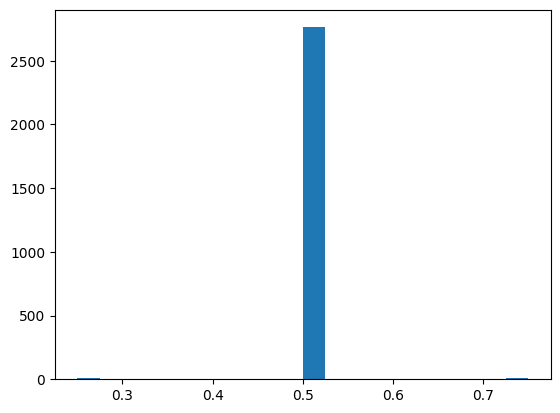

In [18]:
plt.hist(MSFT_m_hid_mh['agg_ratio'], bins=20)
plt.show()

In [19]:
MSFT_m_hid_mh[MSFT_m_hid_mh['agg_ratio'] ==0.5]

,,event_type,order_ID,size,price,direction,event_number_at_t,ask_price_1,ask_size_1,bid_price_1,bid_size_1,ask_price_1_prev,ask_size_1_prev,bid_price_1_prev,bid_size_1_prev,midprice,hid_at_best,agg_ratio
datetime,event_number,,,,,,,,,,,,,,,,,
2012-06-21 09:30:00.039883970,1,5,0,27,309700,-1,2,309900,3788,309500,300,309900.0,3788.0,309500.0,300.0,309700.0,False,0.5
2012-06-21 09:30:02.214995101,0,5,0,100,309650,-1,1,309700,3000,309600,318,309700.0,3000.0,309600.0,318.0,309650.0,False,0.5
2012-06-21 09:30:02.234931207,0,5,0,300,309650,-1,1,309700,3000,309600,318,309700.0,3000.0,309600.0,318.0,309650.0,False,0.5
2012-06-21 09:30:02.263232158,0,5,0,920,309650,-1,1,309700,3000,309600,318,309700.0,3000.0,309600.0,318.0,309650.0,False,0.5
2012-06-21 09:30:02.301006479,0,5,0,100,309650,-1,1,309700,3000,309600,318,309700.0,3000.0,309600.0,318.0,309650.0,False,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21 15:44:42.381660261,0,5,0,100,301450,-1,1,301500,11484,301400,2200,301500.0,11484.0,301400.0,2200.0,301450.0,False,0.5
2012-06-21 15:44:42.401199104,0,5,0,200,301450,-1,1,301500,11484,301400,2200,301500.0,11484.0,301400.0,2200.0,301450.0,False,0.5
2012-06-21 15:44:46.255166394,0,5,0,200,301350,-1,1,301400,18530,301300,12900,301400.0,18530.0,301300.0,12900.0,301350.0,False,0.5


In [20]:
MSFT_m_hid_mh[MSFT_m_hid_mh['event_type']==5]

event_type  order_ID  size  \
datetime                      event_number                               
2012-06-21 09:30:00.039883970 0                      5         0   300   
                              1                      5         0    27   
2012-06-21 09:30:01.628977093 2                      5         0   579   
2012-06-21 09:30:01.746521107 0                      5         0    21   
2012-06-21 09:30:02.214995101 0                      5         0   100   
...                                                ...       ...   ...   
2012-06-21 15:44:42.381660261 0                      5         0   100   
2012-06-21 15:44:42.401199104 0                      5         0   200   
2012-06-21 15:44:46.255166394 0                      5         0   200   
2012-06-21 15:44:54.939982778 3                      5         0   100   
                              4                      5         0   400   

                                             price  direction  \
datetime                      event_number                      
2012-06-21 09:30:00.039883970 0             309600         -1   
                              1             309700         -1   
2012-06-21 09:30:01.628977093 2             309900          1   
2012-06-21 09:30:01.746521107 0             309900          1   
2012-06-21 09:30:02.214995101 0             309650         -1   
...                                            ...        ...   
2012-06-21 15:44:42.381660261 0             301450         -1   
2012-06-21 15:44:42.401199104 0             301450         -1   
2012-06-21 15:44:46.255166394 0             301350         -1   
2012-06-21 15:44:54.939982778 3             301400         -1   
                              4             301400         -1   

                                            event_number_at_t  ask_price_1  \
datetime                      event_number                                   
2012-06-21 09:30:00.039883970 0                             2       309900   
                              1                             2       309900   
2012-06-21 09:30:01.628977093 2                             3       310000   
2012-06-21 09:30:01.746521107 0                             1       310000   
2012-06-21 09:30:02.214995101 0                             1       309700   
...                                                       ...          ...   
2012-06-21 15:44:42.381660261 0                             1       301500   
2012-06-21 15:44:42.401199104 0                             1       301500   
2012-06-21 15:44:46.255166394 0                             1       301400   
2012-06-21 15:44:54.939982778 3                             5       301500   
                              4                             5       301500   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.039883970 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:01.628977093 2                  23106       309700   
2012-06-21 09:30:01.746521107 0                  22906       309700   
2012-06-21 09:30:02.214995101 0                   3000       309600   
...                                                ...          ...   
2012-06-21 15:44:42.381660261 0                  11484       301400   
2012-06-21 15:44:42.401199104 0                  11484       301400   
2012-06-21 15:44:46.255166394 0                  18530       301300   
2012-06-21 15:44:54.939982778 3                  11284       301300   
                              4                  11284       301300   

                                            bid_size_1  ask_price_1_prev  \
datetime                      event_number                                 
2012-06-21 09:30:00.039883970 0                    300          309900.0   
                              1                    300          3099

In [21]:
MSFT_m_hid_mh['midprice'] = (MSFT_m_hid_mh['ask_price_1'] + MSFT_m_hid_mh['bid_price_1']) / 2

Indicator for whether hidden liquidity is at the best bid or ask

In [22]:
MSFT_m_hid_mh['hid_at_best'] = (MSFT_m_hid_mh['price'] == MSFT_m_hid_mh['bid_price_1']) + (MSFT_m_hid_mh['price'] == MSFT_m_hid_mh['ask_price_1'])

How to query particular timestamp.

In [23]:
specific_timestamp = pd.Timestamp('2012-06-21 09:30:00.039883970')
MSFT_m.index.get_loc((specific_timestamp, 0))
# MSFT_m[MSFT_m.index.get_level_values('datetime') == specific_timestamp]

18

In [24]:
MSFT_m.iloc[5:20]

,,event_type,order_ID,size,price,direction,event_number_at_t
datetime,event_number,,,,,,
2012-06-21 09:30:00.016299574,0,1,16116815,100,310700,-1,1
2012-06-21 09:30:00.016405181,0,3,12703297,100,311300,-1,1
2012-06-21 09:30:00.016793836,0,3,12665624,100,311400,-1,1
2012-06-21 09:30:00.017029005,0,3,12665620,100,311500,-1,1
2012-06-21 09:30:00.017173303,0,3,12665619,100,311600,-1,1
2012-06-21 09:30:00.020733481,0,1,16118193,100,310300,-1,1
2012-06-21 09:30:00.020823678,0,3,16116815,100,310700,-1,1
2012-06-21 09:30:00.022011407,0,1,16118930,100,310200,-1,1
2012-06-21 09:30:00.022043001,0,3,16116752,100,310600,-1,1


In [25]:
MSFT_ob.iloc[13:25]

ask_price_1  ask_size_1  \
datetime                      event_number                            
2012-06-21 09:30:00.022043001 0                  309900        3788   
2012-06-21 09:30:00.022343661 0                  309900        3788   
2012-06-21 09:30:00.022408276 0                  309900        3788   
2012-06-21 09:30:00.022512035 0                  309900        3788   
2012-06-21 09:30:00.022532168 0                  309900        3788   
2012-06-21 09:30:00.039883970 0                  309900        3788   
                              1                  309900        3788   
2012-06-21 09:30:00.040031961 0                  309900        3788   
2012-06-21 09:30:00.040074950 0                  309900        3788   
2012-06-21 09:30:00.040118534 0                  309900        3788   
2012-06-21 09:30:00.040131692 0                  309900        3788   
2012-06-21 09:30:00.040163451 0                  309900        3788   

                                            bid_price_1  bid_size_1  \
datetime                      event_number                            
2012-06-21 09:30:00.022043001 0                  309500         300   
2012-06-21 09:30:00.022343661 0                  309500         300   
2012-06-21 09:30:00.022408276 0                  309500         300   
2012-06-21 09:30:00.022512035 0                  309500         300   
2012-06-21 09:30:00.022532168 0                  309500         300   
2012-06-21 09:30:00.039883970 0                  309500         300   
                              1                  309500         300   
2012-06-21 09:30:00.040031961 0                  309500         300   
2012-06-21 09:30:00.040074950 0                  309500         300   
2012-06-21 09:30:00.040118534 0                  309500         300   
2012-06-21 09:30:00.040131692 0                  309500         300   
2012-06-21 09:30:00.040163451 0                  309500         300   

                                            ask_price_2  ask_size_2  \
datetime                      event_number                            
2012-06-21 09:30:00.022043001 0                  310200         100   
2012-06-21 09:30:00.022343661 0                  310100         100   
2012-06-21 09:30:00.022408276 0                  310100         100   
2012-06-21 09:30:00.022512035 0                  310000         100   
2012-06-21 09:30:00.022532168 0                  310000         100   
2012-06-21 09:30:00.039883970 0                  310000         100   
                              1                  310000         100   
2012-06-21 09:30:00.040031961 0                  310000         100   
2012-06-21 09:30:00.040074950 0                  310000         100   
2012-06-21 09:30:00.040118534 0                  310000         100   
2012-06-21 09:30:00.040131692 0                  310000         100   
2012-06-21 09:30:00.040163451 0                  310000         100   

                                            bid_price_2  bid_size_2  \
datetime                      event_number                            
2012-06-21 09:30:00.022043001 0                  309300        3986   
2012-06-21 09:30:00.022343661 0                  309300        3986   
2012-06-21 09:30:00.022408276 0                  309300        3986   
2012-06-21 09:30:00.022512035 0                  309300        3986   
2012-06-21 09:30:00.022532168 0                  309300        3986   
2012-06-21 09:30:00.039883970 0                  309300        3986   
                              1                  309300        3986   
2012-06-21 09:30:00.040031961 0                  309300        3986   
2012-06-21 09:30:00.040074950 0                  309300        3986   
2012-06-21 09:30:00.040118534 0                  309300        3986   
2012-06-21 09:30:00.040131692 0                  309400         100   
2012-06-21 09:30:00.040163451 0                  309400         100   

                                            ask_price_3  ask_siz

In [26]:
MSFT_m_hid_mh['agg_ratio'] = (MSFT_m_hid_mh['price'] - MSFT_m_hid_mh['bid_price_1']) / (MSFT_m_hid_mh['ask_price_1'] - MSFT_m_hid_mh['bid_price_1'])

# get rid of rows where ratio is greater than 1 or less than 0, since it is not within bid-ask spread
MSFT_m_hid_mh = MSFT_m_hid_mh[(MSFT_m_hid_mh['agg_ratio'] >= 0) & (MSFT_m_hid_mh['agg_ratio'] <= 1)]

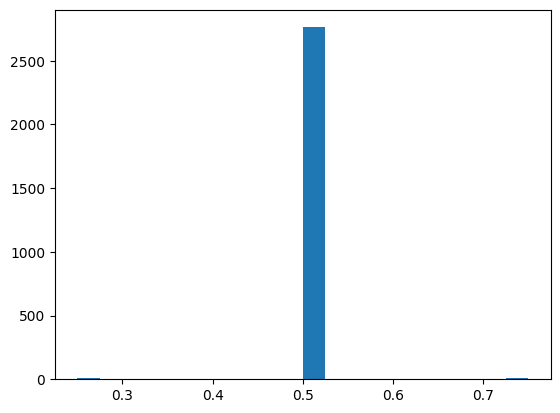

In [27]:
plt.hist(MSFT_m_hid_mh['agg_ratio'], bins=20)
plt.show()

(array([2.810e+02, 1.515e+03, 4.610e+02, 1.300e+02, 1.020e+02, 8.600e+01,
        4.100e+01, 2.600e+01, 3.000e+01, 2.200e+01, 1.900e+01, 1.100e+01,
        1.100e+01, 8.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 6.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 9.4300e+01, 1.8760e+02, 2.8090e+02, 3.7420e+02,
        4.6750e+02, 5.6080e+02, 6.5410e+02, 7.4740e+02, 8.4070e+02,
        9.3400e+02, 1.0273e+03, 1.1206e+03, 1.2139e+03, 1.3072e+03,
        1.4005e+03, 1.4938e+03, 1.5871e+03, 1.6804e+03, 1.7737e+03,
        1.8670e+03, 1.9603e+03, 2.0536e+03, 2.1469e+03, 2.2402e+03,
        2.3335e+03, 2.4268e+03, 2.5201e+03, 2.6134e+03, 2.7067e+03,
        2.8000e+03]),
 <BarContainer object of 30 artists>)

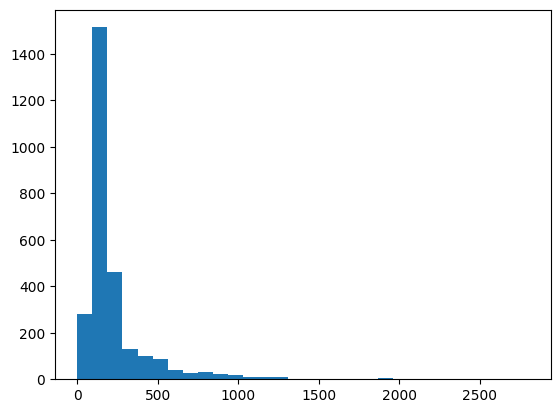

In [28]:
plt.hist(np.sort(MSFT_m_hid_mh['size'])[:-20], bins=30)

In [29]:
MSFT_m_hid_mh[~MSFT_m_hid_mh['hid_at_best']]

event_type  order_ID  size  \
datetime                      event_number                               
2012-06-21 09:30:00.039883970 0                      5         0   300   
                              1                      5         0    27   
2012-06-21 09:30:01.628977093 2                      5         0   579   
2012-06-21 09:30:01.746521107 0                      5         0    21   
2012-06-21 09:30:02.214995101 0                      5         0   100   
...                                                ...       ...   ...   
2012-06-21 15:44:42.381660261 0                      5         0   100   
2012-06-21 15:44:42.401199104 0                      5         0   200   
2012-06-21 15:44:46.255166394 0                      5         0   200   
2012-06-21 15:44:54.939982778 3                      5         0   100   
                              4                      5         0   400   

                                             price  direction  \
datetime                      event_number                      
2012-06-21 09:30:00.039883970 0             309600         -1   
                              1             309700         -1   
2012-06-21 09:30:01.628977093 2             309900          1   
2012-06-21 09:30:01.746521107 0             309900          1   
2012-06-21 09:30:02.214995101 0             309650         -1   
...                                            ...        ...   
2012-06-21 15:44:42.381660261 0             301450         -1   
2012-06-21 15:44:42.401199104 0             301450         -1   
2012-06-21 15:44:46.255166394 0             301350         -1   
2012-06-21 15:44:54.939982778 3             301400         -1   
                              4             301400         -1   

                                            event_number_at_t  ask_price_1  \
datetime                      event_number                                   
2012-06-21 09:30:00.039883970 0                             2       309900   
                              1                             2       309900   
2012-06-21 09:30:01.628977093 2                             3       310000   
2012-06-21 09:30:01.746521107 0                             1       310000   
2012-06-21 09:30:02.214995101 0                             1       309700   
...                                                       ...          ...   
2012-06-21 15:44:42.381660261 0                             1       301500   
2012-06-21 15:44:42.401199104 0                             1       301500   
2012-06-21 15:44:46.255166394 0                             1       301400   
2012-06-21 15:44:54.939982778 3                             5       301500   
                              4                             5       301500   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.039883970 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:01.628977093 2                  23106       309700   
2012-06-21 09:30:01.746521107 0                  22906       309700   
2012-06-21 09:30:02.214995101 0                   3000       309600   
...                                                ...          ...   
2012-06-21 15:44:42.381660261 0                  11484       301400   
2012-06-21 15:44:42.401199104 0                  11484       301400   
2012-06-21 15:44:46.255166394 0                  18530       301300   
2012-06-21 15:44:54.939982778 3                  11284       301300   
                              4                  11284       301300   

                                            bid_size_1  ask_price_1_prev  \
datetime                      event_number                                 
2012-06-21 09:30:00.039883970 0                    300          309900.0   
                              1                    300          3099

(array([  10.,    0., 2763.,    0.,   15.]),
 array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75]),
 <BarContainer object of 5 artists>)

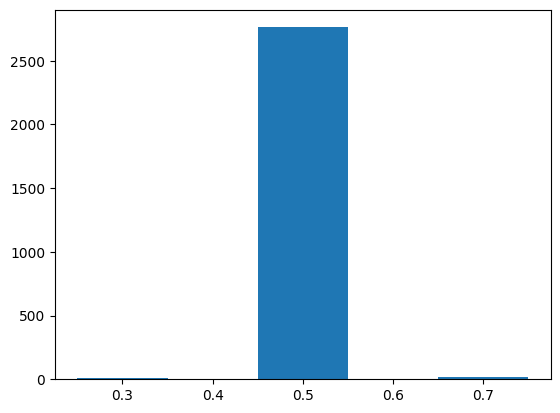

In [30]:
plt.hist(MSFT_m_hid_mh[~MSFT_m_hid_mh['hid_at_best']]['agg_ratio'], bins=5)

In [31]:
MSFT_m_hid_mh['est_dir'] = 0

We try to infer the direction of hidden order executions

In [32]:
MSFT_m_hid_mh['est_dir'] = MSFT_m_hid_mh.apply(
    lambda row: -1 if row['hid_at_best'] == 1 and row['agg_ratio'] > 0 else (1 if row['hid_at_best'] == 1 else 0),
    axis=1
)

Timestamps where there are multiple events where atleast one event is of type 5

In [33]:
mult_event_hid_idx = MSFT_m.index.get_level_values('datetime').isin(MSFT_m_hid_mh[MSFT_m_hid_mh['event_number_at_t'] != 1].index.get_level_values('datetime'))

Timestamp with multi-event where there is a visible buy or sell limit order (event_type 4), we set 5 to the same corresponding direction.

In [34]:
idx_mult_event_buy_vis = MSFT_m[mult_event_hid_idx][(MSFT_m[mult_event_hid_idx]['event_type'] == 4) & (MSFT_m[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_event_sell_vis = MSFT_m[mult_event_hid_idx][(MSFT_m[mult_event_hid_idx]['event_type'] == 4) & (MSFT_m[mult_event_hid_idx]['direction'] == -1)].index

In [35]:
dt_mult_event_buy_vis = idx_mult_event_buy_vis.get_level_values('datetime').unique()
dt_mult_event_sell_vis = idx_mult_event_sell_vis.get_level_values('datetime').unique()

In [36]:
MSFT_m_hid_mh.loc[MSFT_m_hid_mh.index.get_level_values('datetime').isin(dt_mult_event_buy_vis), 'est_dir'] = 1
MSFT_m_hid_mh.loc[MSFT_m_hid_mh.index.get_level_values('datetime').isin(dt_mult_event_sell_vis), 'est_dir'] = -1

In [37]:
sum((MSFT_m_hid_mh['est_dir'] != 0) & (MSFT_m_hid_mh['est_dir'] != MSFT_m_hid_mh['direction']))

0

In [38]:
MSFT_m_hid_mh['est_dir']

datetime                       event_number
2012-06-21 09:30:00.039883970  0               0
                               1               0
2012-06-21 09:30:01.628977093  2               1
2012-06-21 09:30:01.746521107  0               0
2012-06-21 09:30:02.214995101  0               0
                                              ..
2012-06-21 15:44:42.381660261  0               0
2012-06-21 15:44:42.401199104  0               0
2012-06-21 15:44:46.255166394  0               0
2012-06-21 15:44:54.939982778  3              -1
                               4              -1
Name: est_dir, Length: 2788, dtype: int64

Timestamp with multi-event where there is a visible buy or sell limit order (event_type 1), we set 5 to the opposite corresponding direction.

In [39]:
idx_mult_event_buy_vis_1 = MSFT_m[mult_event_hid_idx][(MSFT_m[mult_event_hid_idx]['event_type'] == 1) & (MSFT_m[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_event_sell_vis_1 = MSFT_m[mult_event_hid_idx][(MSFT_m[mult_event_hid_idx]['event_type'] == 1) & (MSFT_m[mult_event_hid_idx]['direction'] == -1)].index

In [40]:
dt_mult_event_buy_vis_1 = idx_mult_event_buy_vis_1.get_level_values('datetime').unique()
dt_mult_event_sell_vis_1 = idx_mult_event_sell_vis_1.get_level_values('datetime').unique()

In [41]:
MSFT_m_hid_mh.loc[MSFT_m_hid_mh.index.get_level_values('datetime').isin(dt_mult_event_buy_vis_1), 'est_dir'] = -1
MSFT_m_hid_mh.loc[MSFT_m_hid_mh.index.get_level_values('datetime').isin(dt_mult_event_sell_vis_1), 'est_dir'] = 1

In [42]:
sum((MSFT_m_hid_mh['est_dir'] != 0) & (MSFT_m_hid_mh['est_dir'] != MSFT_m_hid_mh['direction']))

0

In [43]:
sum(MSFT_m_hid_mh['est_dir'] == 0)

1593

In [44]:
MSFT_m_hid_mh[MSFT_m_hid_mh['est_dir'] == 0]

event_type  order_ID  size  \
datetime                      event_number                               
2012-06-21 09:30:00.039883970 0                      5         0   300   
                              1                      5         0    27   
2012-06-21 09:30:01.746521107 0                      5         0    21   
2012-06-21 09:30:02.214995101 0                      5         0   100   
2012-06-21 09:30:02.234931207 0                      5         0   300   
...                                                ...       ...   ...   
2012-06-21 15:44:37.920198715 0                      5         0    20   
2012-06-21 15:44:37.924957775 0                      5         0   100   
2012-06-21 15:44:42.381660261 0                      5         0   100   
2012-06-21 15:44:42.401199104 0                      5         0   200   
2012-06-21 15:44:46.255166394 0                      5         0   200   

                                             price  direction  \
datetime                      event_number                      
2012-06-21 09:30:00.039883970 0             309600         -1   
                              1             309700         -1   
2012-06-21 09:30:01.746521107 0             309900          1   
2012-06-21 09:30:02.214995101 0             309650         -1   
2012-06-21 09:30:02.234931207 0             309650         -1   
...                                            ...        ...   
2012-06-21 15:44:37.920198715 0             301450         -1   
2012-06-21 15:44:37.924957775 0             301450         -1   
2012-06-21 15:44:42.381660261 0             301450         -1   
2012-06-21 15:44:42.401199104 0             301450         -1   
2012-06-21 15:44:46.255166394 0             301350         -1   

                                            event_number_at_t  ask_price_1  \
datetime                      event_number                                   
2012-06-21 09:30:00.039883970 0                             2       309900   
                              1                             2       309900   
2012-06-21 09:30:01.746521107 0                             1       310000   
2012-06-21 09:30:02.214995101 0                             1       309700   
2012-06-21 09:30:02.234931207 0                             1       309700   
...                                                       ...          ...   
2012-06-21 15:44:37.920198715 0                             1       301500   
2012-06-21 15:44:37.924957775 0                             1       301500   
2012-06-21 15:44:42.381660261 0                             1       301500   
2012-06-21 15:44:42.401199104 0                             1       301500   
2012-06-21 15:44:46.255166394 0                             1       301400   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.039883970 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:01.746521107 0                  22906       309700   
2012-06-21 09:30:02.214995101 0                   3000       309600   
2012-06-21 09:30:02.234931207 0                   3000       309600   
...                                                ...          ...   
2012-06-21 15:44:37.920198715 0                  11284       301400   
2012-06-21 15:44:37.924957775 0                  11284       301400   
2012-06-21 15:44:42.381660261 0                  11484       301400   
2012-06-21 15:44:42.401199104 0                  11484       301400   
2012-06-21 15:44:46.255166394 0                  18530       301300   

                                            bid_size_1  ask_price_1_prev  \
datetime                      event_number                                 
2012-06-21 09:30:00.039883970 0                    300          309900.0   
                              1                    300          3099

Tagging direction based on next submission of limit order at the same price in a small delta timeframe.

In [45]:
# def update_direction_infer_t4(df1, df2, delta, indices):
#     # Filter df2 to get relevant rows within the time range for all indices
#     min_time = min(indices)
#     max_time = max(indices) + delta
#     df2_filtered = df2[(df2.index.get_level_values('datetime') >= min_time) & 
#                        (df2.index.get_level_values('datetime') <= max_time) & 
#                        (df2['event_type'] == 4)]
    
#     # Reset index to use merge_asof
#     df1_reset = df1.reset_index()
#     df2_filtered_reset = df2_filtered.reset_index()
    
#     # Perform asof merge to find the closest match within the delta time
#     merged = pd.merge_asof(df1_reset, df2_filtered_reset, 
#                            by='price', 
#                            left_on='datetime', 
#                            right_on='datetime', 
#                            tolerance=delta, 
#                            direction='backward')
    
#     merged['direction_y'].fillna(0, inplace=True)


#     return merged

In [46]:
# desired_hid_idx = MSFT_m_hid_mh[MSFT_m_hid_mh['est_dir']==0].index
# desired_hid_idx = desired_hid_idx.get_level_values('datetime').unique()

In [47]:
# delta = pd.Timedelta(seconds=0.00001)
# merged4 = update_direction_infer_t4(MSFT_m_hid_mh, MSFT_m, delta, desired_hid_idx)


In [48]:
# direction_y_series4 = merged4['direction_y']
# direction_y_series4.index = MSFT_m_hid_mh.index

# MSFT_m_hid_mh['est_dir'] = np.where((direction_y_series4 != 0) & (MSFT_m_hid_mh['est_dir'] == 0), direction_y_series4, MSFT_m_hid_mh['est_dir'])

In [49]:
# sum(MSFT_m_hid_mh['est_dir'] == 0)

In [50]:
# desired_hid_idx = MSFT_m_hid_mh[MSFT_m_hid_mh['est_dir']==0].index
# desired_hid_idx = desired_hid_idx.get_level_values('datetime').unique()

In [51]:
# desired_hid_idx

In [52]:
# def update_direction_infer_t1(df1, df2, delta, indices):
#     # Filter df2 to get relevant rows within the time range for all indices
#     min_time = min(indices)
#     max_time = max(indices) + delta
#     df2_filtered = df2[(df2.index.get_level_values('datetime') >= min_time) & 
#                        (df2.index.get_level_values('datetime') <= max_time) & 
#                        (df2['event_type'] == 1)]
    
#     # Reset index to use merge_asof
#     df1_reset = df1.reset_index()
#     df2_filtered_reset = df2_filtered.reset_index()
    
#     # Perform asof merge to find the closest match within the delta time
#     merged = pd.merge_asof(df1_reset, df2_filtered_reset, 
#                            # by='price', 
#                            left_on='datetime', 
#                            right_on='datetime', 
#                            tolerance=delta, 
#                            direction='forward')
    
#     merged['direction_y'].fillna(0, inplace=True)


#     return merged


In [53]:
# delta = pd.Timedelta(seconds=0.05)
# merged = update_direction_infer_t1(MSFT_m_hid_mh, MSFT_m, delta, desired_hid_idx)


In [54]:
# direction_y_series = merged['direction_y']
# direction_y_series.index = MSFT_m_hid_mh.index

In [55]:
# MSFT_m_hid_mh['est_dir'] = np.where((direction_y_series != 0) & (MSFT_m_hid_mh['est_dir'] == 0), - direction_y_series, MSFT_m_hid_mh['est_dir'])

In [56]:
# sum(MSFT_m_hid_mh['est_dir'] == 0)

In [57]:
# plt.hist(MSFT_m_hid_mh['est_dir'])

In [58]:
# sum((MSFT_m_hid_mh['est_dir'] != 0) & (MSFT_m_hid_mh['est_dir'] != MSFT_m_hid_mh['direction']))

In [59]:
# MSFT_m_hid_mh[(MSFT_m_hid_mh['est_dir'] != 0) & (MSFT_m_hid_mh['est_dir'] != MSFT_m_hid_mh['direction'])]

In [60]:
# specific_timestamp = pd.Timestamp('2012-06-21 09:30:00.317289601')
# MSFT_m.index.get_loc((specific_timestamp, 0))
# # MSFT_m[MSFT_m.index.get_level_values('datetime') == specific_timestamp]

In [61]:
# MSFT_m[MSFT_m['order_ID']==4886246]

In [62]:
# MSFT_m_hid_mh[MSFT_m_hid_mh['est_dir']==0]

In [63]:
# MSFT_m.iloc[405:435]

In [64]:
MSFT_ob['mid_price'] = (MSFT_ob['bid_price_1'] + MSFT_ob['ask_price_1']) / 2

In [65]:
MSFT_ob['order_imb'] = (MSFT_ob['bid_size_1'] - MSFT_ob['ask_size_1']) / (MSFT_ob['bid_size_1'] + MSFT_ob['ask_size_1'])

In [66]:
# Get the list of columns
columns = list(MSFT_ob.columns)

# Identify the last two columns
last_two_columns = columns[-2:]

# Create a new order with the last two columns at the front
new_order = last_two_columns + columns[:-2]

# Reorder the DataFrame
MSFT_ob = MSFT_ob[new_order]

In [67]:
MSFT_ob

mid_price  order_imb  ask_price_1  \
datetime                      event_number                                      
2012-06-21 09:30:00.013994120 0              309700.0  -0.853229       309900   
                              1              309700.0  -0.853229       309900   
2012-06-21 09:30:00.015247805 0              309700.0  -0.853229       309900   
2012-06-21 09:30:00.015442111 0              309700.0  -0.853229       309900   
2012-06-21 09:30:00.015789148 0              309700.0  -0.853229       309900   
...                                               ...        ...          ...   
2012-06-21 15:59:59.861465727 0              301350.0   0.487295       301400   
2012-06-21 15:59:59.861566671 0              301350.0   0.504670       301400   
2012-06-21 15:59:59.873177404 0              301350.0   0.504670       301400   
2012-06-21 15:59:59.907796528 0              301350.0   0.504670       301400   
                              1              301350.0   0.504670       301400   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.013994120 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:00.015247805 0                   3788       309500   
2012-06-21 09:30:00.015442111 0                   3788       309500   
2012-06-21 09:30:00.015789148 0                   3788       309500   
...                                                ...          ...   
2012-06-21 15:59:59.861465727 0                  17383       301300   
2012-06-21 15:59:59.861566671 0                  16600       301300   
2012-06-21 15:59:59.873177404 0                  16600       301300   
2012-06-21 15:59:59.907796528 0                  16600       301300   
                              1                  16600       301300   

                                            bid_size_1  ask_price_2  \
datetime                      event_number                            
2012-06-21 09:30:00.013994120 0                    300       310500   
                              1                    300       310500   
2012-06-21 09:30:00.015247805 0                    300       310400   
2012-06-21 09:30:00.015442111 0                    300       310400   
2012-06-21 09:30:00.015789148 0                    300       310400   
...                                                ...          ...   
2012-06-21 15:59:59.861465727 0                  50426       301500   
2012-06-21 15:59:59.861566671 0                  50426       301500   
2012-06-21 15:59:59.873177404 0                  50426       301500   
2012-06-21 15:59:59.907796528 0                  50426       301500   
                              1                  50426       301500   

                                            ask_size_2  bid_price_2  \
datetime                      event_number                            
2012-06-21 09:30:00.013994120 0                    100       309300   
                              1                    200       309300   
2012-06-21 09:30:00.015247805 0                    100       309300   
2012-06-21 09:30:00.015442111 0                    100       309300   
2012-06-21 09:30:00.015789148 0                    100       309300   
...                                                ...          ...   
2012-06-21 15:59:59.861465727 0                  81463       301200   
2012-06-21 15:59:59.861566671 0                  81463       301200   
2012-06-21 15:59:59.873177404 0                  80663       301200   
2012-06-21 15:59:59.907796528 0                  80663       301200   
                              1                  80663       301200   

                                            bid_size_2  ask_price_3  \
datetime                      event_number                            
2012-06-21 09:30:00.013994120 0                   3986       310600   
     

In [68]:
MSFT_m_hid_mh

event_type  order_ID  size  \
datetime                      event_number                               
2012-06-21 09:30:00.039883970 0                      5         0   300   
                              1                      5         0    27   
2012-06-21 09:30:01.628977093 2                      5         0   579   
2012-06-21 09:30:01.746521107 0                      5         0    21   
2012-06-21 09:30:02.214995101 0                      5         0   100   
...                                                ...       ...   ...   
2012-06-21 15:44:42.381660261 0                      5         0   100   
2012-06-21 15:44:42.401199104 0                      5         0   200   
2012-06-21 15:44:46.255166394 0                      5         0   200   
2012-06-21 15:44:54.939982778 3                      5         0   100   
                              4                      5         0   400   

                                             price  direction  \
datetime                      event_number                      
2012-06-21 09:30:00.039883970 0             309600         -1   
                              1             309700         -1   
2012-06-21 09:30:01.628977093 2             309900          1   
2012-06-21 09:30:01.746521107 0             309900          1   
2012-06-21 09:30:02.214995101 0             309650         -1   
...                                            ...        ...   
2012-06-21 15:44:42.381660261 0             301450         -1   
2012-06-21 15:44:42.401199104 0             301450         -1   
2012-06-21 15:44:46.255166394 0             301350         -1   
2012-06-21 15:44:54.939982778 3             301400         -1   
                              4             301400         -1   

                                            event_number_at_t  ask_price_1  \
datetime                      event_number                                   
2012-06-21 09:30:00.039883970 0                             2       309900   
                              1                             2       309900   
2012-06-21 09:30:01.628977093 2                             3       310000   
2012-06-21 09:30:01.746521107 0                             1       310000   
2012-06-21 09:30:02.214995101 0                             1       309700   
...                                                       ...          ...   
2012-06-21 15:44:42.381660261 0                             1       301500   
2012-06-21 15:44:42.401199104 0                             1       301500   
2012-06-21 15:44:46.255166394 0                             1       301400   
2012-06-21 15:44:54.939982778 3                             5       301500   
                              4                             5       301500   

                                            ask_size_1  bid_price_1  \
datetime                      event_number                            
2012-06-21 09:30:00.039883970 0                   3788       309500   
                              1                   3788       309500   
2012-06-21 09:30:01.628977093 2                  23106       309700   
2012-06-21 09:30:01.746521107 0                  22906       309700   
2012-06-21 09:30:02.214995101 0                   3000       309600   
...                                                ...          ...   
2012-06-21 15:44:42.381660261 0                  11484       301400   
2012-06-21 15:44:42.401199104 0                  11484       301400   
2012-06-21 15:44:46.255166394 0                  18530       301300   
2012-06-21 15:44:54.939982778 3                  11284       301300   
                              4                  11284       301300   

                                            bid_size_1  ask_price_1_prev  \
datetime                      event_number                                 
2012-06-21 09:30:00.039883970 0                    300          309900.0   
                              1                    300          3099

We try to run ML models to predict the direction of hidden liquidity execution - these features mainly only make sense for event type 5

In [69]:
MSFT_m_hid_mh.drop(columns=['ask_price_1_prev', 'ask_size_1_prev', 'bid_price_1_prev', 'bid_size_1_prev'], inplace=True)

In [86]:
MSFT_m['prev_dir_t1'] = np.where(MSFT_m['event_type']==1, MSFT_m['direction'], np.nan)
MSFT_m['prev_dir_t1'] = MSFT_m['prev_dir_t1'].shift(1).ffill()
MSFT_m['prev_dir_t1'].fillna(0, inplace=True)

In [87]:
MSFT_m['next_dir_t1'] = np.where(MSFT_m['event_type']==1, MSFT_m['direction'], np.nan)
MSFT_m['next_dir_t1'] = MSFT_m['next_dir_t1'].shift(-1).bfill()
MSFT_m['next_dir_t1'].fillna(0, inplace=True)

In [91]:
MSFT_m['prev_dir_t4'] = np.where(MSFT_m['event_type']==4, MSFT_m['direction'], np.nan)
MSFT_m['prev_dir_t4'] = MSFT_m['prev_dir_t4'].shift(1).ffill()
MSFT_m['prev_dir_t4'].fillna(0, inplace=True)

In [92]:
MSFT_m['next_dir_t4'] = np.where(MSFT_m['event_type']==4, MSFT_m['direction'], np.nan)
MSFT_m['next_dir_t4'] = MSFT_m['next_dir_t4'].shift(-1).bfill()
MSFT_m['next_dir_t4'].fillna(0, inplace=True)

In [95]:
MSFT_m['mid_price'] = MSFT_ob['mid_price']
MSFT_m['order_imb'] = MSFT_ob['order_imb']


In [97]:
MSFT_m['bid_price_1'] = MSFT_ob['bid_price_1']
MSFT_m['ask_price_1'] = MSFT_ob['ask_price_1']
MSFT_m['agg_ratio'] = (MSFT_m['price'] - MSFT_m['bid_price_1']) / (MSFT_m['ask_price_1'] - MSFT_m['bid_price_1'])

In [107]:
MSFT_m['hid_at_best'] = (MSFT_m['price'] == MSFT_m['bid_price_1']).astype(int) - (MSFT_m['price'] == MSFT_m['ask_price_1']).astype(int)

Encode general sentiment at that moment in time, we look at the number of trades (changes to the LOB) interested in buying/selling - still need to think about this.

Filter for the features in the ML model

In [109]:
features_hid = MSFT_m[MSFT_m['event_type']==5]

In [112]:
features_hid.drop(columns=['event_type', 'order_ID', 'direction'], inplace=True)

In [113]:
outcome_hid = MSFT_m[MSFT_m['event_type']==5]['direction']

In [116]:
X_train, X_test, y_train, y_test = train_test_split(features_hid, outcome_hid, test_size=0.25, random_state=42)

In [120]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [132]:
sum(y_pred == list(y_test))/len(y_pred)

np.float64(0.7942477876106194)